In [1]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
from dce import DCE
from cluster import Cluster
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Model
%matplotlib inline
from rdkit.Chem import MACCSkeys

Using TensorFlow backend.


(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

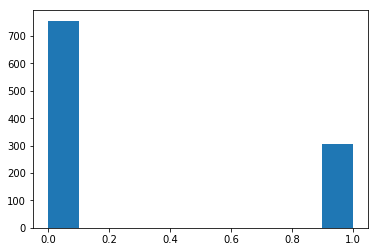

In [2]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])

df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(true_label_biclass)

In [3]:
from descriptor import rdkitDescriptors as rDesc
fps = rDesc.batch_compute_MACCSkeys(df['SMILES'])

In [4]:
sns.set(style='white', font_scale=3)

## 1. Baseline Model: Kmeans

In [5]:
from cluster import KMeans
kmeans_cluster = KMeans(n_clusters=2)
kmeans_cluster.build_model()
kmeans_cluster.train_model(fps, true_labels=true_label_biclass)

Metrics without ture labels
silhouette score: 0.10902037724799786
calinski score: 134.24936032139317

Metric with True label
adjusted rand score: 0.15512829690464983 
fowlkes_mallows : 0.6198828979777116


(array([1, 0, 1, ..., 1, 1, 0], dtype=int32),
 {'silhouette_score': 0.10902037724799786,
  'calinski_score': 134.24936032139317,
  'adjusted_rand_score': 0.15512829690464983,
  'fowlkes_mallows_score': 0.6198828979777116})

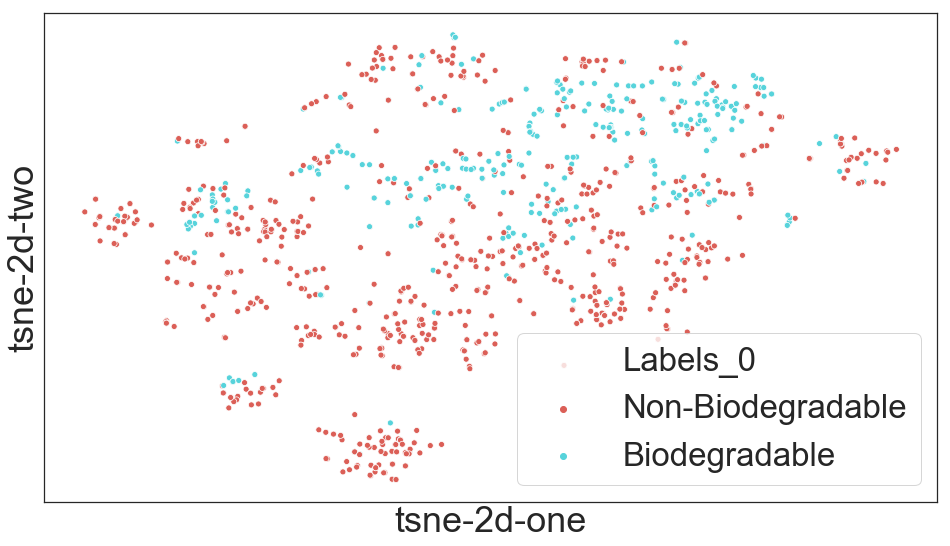

In [6]:
fig, ax=plt.subplots(1,1, figsize=(16,9))
utilities.tsne_2d_visulization(input_feat=fps, 
                               plot_labels=true_label_biclass,
                               labels=['Non-Biodegradable', 'Biodegradable'],
                               verbose=0,
                               ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.legend()
plt.savefig('1.baseline_model.pdf', bbox_inches='tight')

## 2. Two-step Training: Autoencoder + KMeans

In [7]:
from dimreducer import DeepAutoEncoder as DAE
dims = [167, 120, 60]
autoencoder = DAE(dims, act='relu')
autoencoder.build_model(norm=False)
history = autoencoder.train_model(fps, loss="binary_crossentropy", verbose=0, epochs=60)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


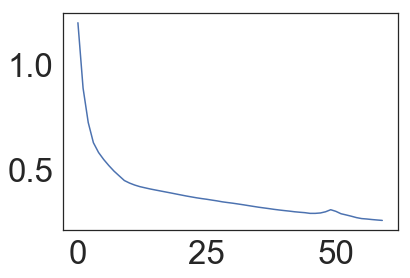

In [8]:
plt.plot(history.history['loss'])

In [9]:
encoder = Model(inputs=autoencoder.model.input, 
                outputs=autoencoder.model.get_layer(name='embedding_layer').output)
hidden_feat = encoder.predict(fps)

In [10]:
kmeans_cluster = KMeans(n_clusters=2)
kmeans_cluster.build_model()
kmeans_cluster.train_model(hidden_feat, true_labels=true_label_biclass)

Metrics without ture labels
silhouette score: 0.20731017
calinski score: 207.74707598506296

Metric with True label
adjusted rand score: -0.025130626888831394 
fowlkes_mallows : 0.5676812843017691


(array([1, 0, 0, ..., 1, 0, 0], dtype=int32),
 {'silhouette_score': 0.20731017,
  'calinski_score': 207.74707598506296,
  'adjusted_rand_score': -0.025130626888831394,
  'fowlkes_mallows_score': 0.5676812843017691})

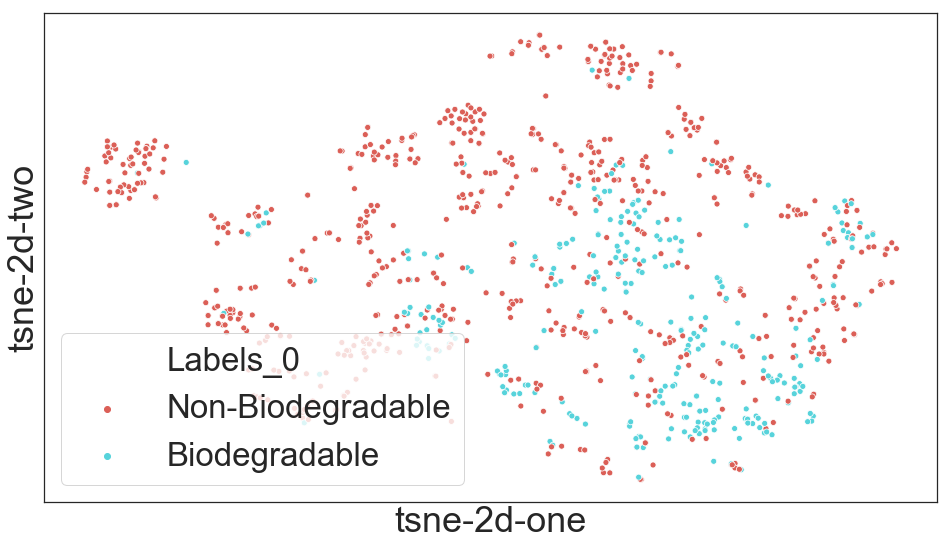

In [11]:
fig, ax=plt.subplots(1,1, figsize=(16,9))
utilities.tsne_2d_visulization(input_feat=hidden_feat, 
                               plot_labels=true_label_biclass,
                               labels=['Non-Biodegradable', 'Biodegradable'],
                               verbose=0,
                               ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.legend()
plt.savefig('2.two_step_train.pdf', bbox_inches='tight')

## 3. Simultaneous training: Autoencoder + Clustering

In [12]:
from dce import DCE
autoencoder_dims = [167, 120, 60]

In [13]:
cl_weight = 0.5
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=20)
dce.build_model(norm=False)
loss = dce.train_model(
            data_train=fps, 
            clustering_loss='kld', decoder_loss='binary_crossentropy',
            verbose=0,clustering_loss_weight=cl_weight)
    
q, _ = dce.model.predict(fps)
y_pred = q.argmax(1)
    
encoder = Model(inputs=dce.model.input, 
                outputs=dce.model.get_layer(name='embedding_layer').output)
    
hidden_feats = encoder.predict(fps)

0.0 < 0.0001
Reached tolerance threshold. Stopping training.


Text(0.5, 1.0, 'clustering weight: 0.5')

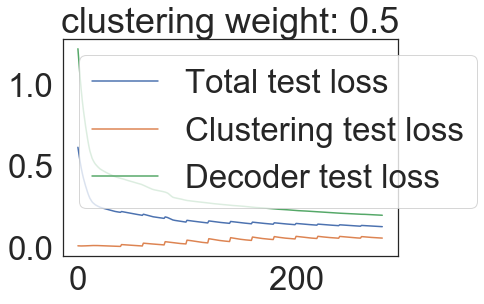

In [14]:
plt.plot(loss[0],label='Total test loss')
plt.plot(loss[1],label='Clustering test loss')
plt.plot(loss[2],label='Decoder test loss')
plt.legend()
plt.title('clustering weight: ' + str(cl_weight))

In [15]:
Cluster.true_label_metrics(true_label_biclass,y_pred,print_metric=False)

{'adjusted_rand_score': 0.02873683841423917,
 'fowlkes_mallows_score': 0.5682827107067747}

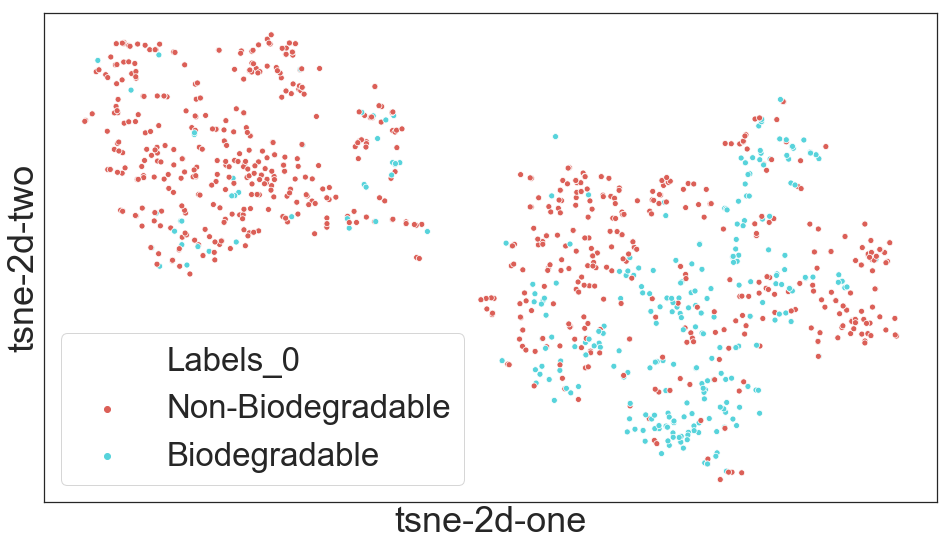

In [16]:
fig, ax=plt.subplots(1,1, figsize=(16,9))
utilities.tsne_2d_visulization(input_feat=hidden_feats, 
                               plot_labels=true_label_biclass,
                               labels=['Non-Biodegradable', 'Biodegradable'],
                               verbose=0,
                               ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.legend()
plt.savefig('3.co_train_clustering.pdf', bbox_inches='tight')

## 4. Simultaneous training: Autoencoder + Classification

In [17]:
class_names = np.array(["Non-biodegradable", "Biodegradable"])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    fps, true_label_biclass, test_size=0.25, random_state=42)

In [18]:
cl_weight = 0.5
autoencoder_dims = [167, 120, 60]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=20)

dce.build_model(norm=False)

train_loss, test_loss = dce.train_model(data_train=X_train, labels_train=y_train,
                                        data_test=X_test, labels_test=y_test,
                                        clustering_loss='kld', decoder_loss='binary_crossentropy',
                                        verbose=0,clustering_loss_weight=cl_weight)

q, _ = dce.model.predict(X_train)
train_y_pred = q.argmax(1)
    
q, _ = dce.model.predict(X_test)
test_y_pred = q.argmax(1)
    
encoder = Model(inputs=dce.model.input, 
                outputs=dce.model.get_layer(name='embedding_layer').output)
    
train_hidden_feats = encoder.predict(X_train)
test_hidden_feats = encoder.predict(X_test)


0.0 < 0.0001
Reached tolerance threshold. Stopping training.


Text(0.5, 1.0, 'clustering weight: 0.5')

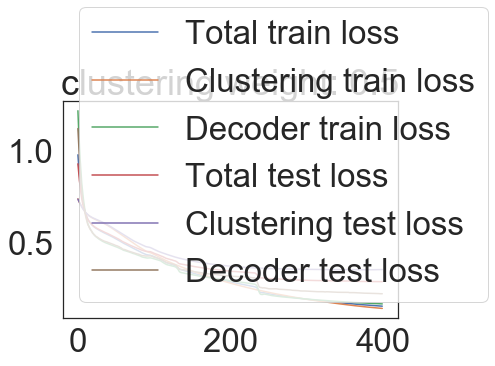

In [19]:
plt.plot(train_loss[0],label='Total train loss')
plt.plot(train_loss[1],label='Clustering train loss')
plt.plot(train_loss[2],label='Decoder train loss')
plt.plot(test_loss[0],label='Total test loss')
plt.plot(test_loss[1],label='Clustering test loss')
plt.plot(test_loss[2],label='Decoder test loss')
plt.legend()
plt.title('clustering weight: ' + str(cl_weight))

In [20]:
print('Train Score:')
Cluster.true_label_metrics(y_train,train_y_pred,print_metric=True)

print('Test Score:')
Cluster.true_label_metrics(y_test,test_y_pred,print_metric=True)


Train Score:
Metric with True label
adjusted rand score: 0.9185774193128209 
fowlkes_mallows : 0.9666139247209543
Test Score:
Metric with True label
adjusted rand score: 0.4836338026749536 
fowlkes_mallows : 0.7843978240122444


{'adjusted_rand_score': 0.4836338026749536,
 'fowlkes_mallows_score': 0.7843978240122444}

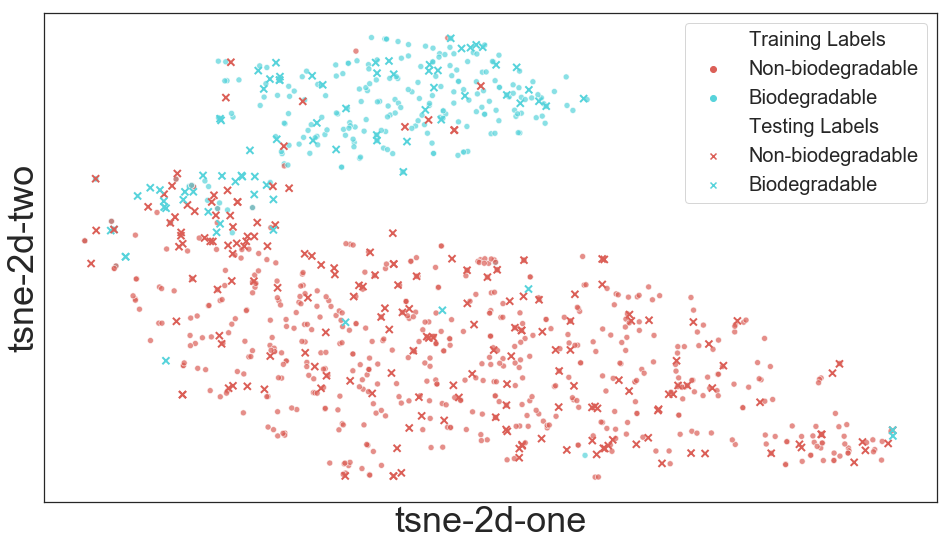

In [23]:
fig, ax =plt.subplots(figsize=(16,9))

utilities.tsne_2d_visulization_test_and_train(
    train_feat=train_hidden_feats, 
    train_labels=y_train,
    test_feat=test_hidden_feats,
    test_labels=y_test,
    labels=['Non-biodegradable', 'Biodegradable'],
    verbose=0,
    ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.legend(fontsize=20)
plt.savefig('4.co_train_classifying.pdf', bbox_inches='tight')